In [8]:
import networkx as nx 
import random
import numpy as np
import matplotlib.pyplot as plt
import abc
from abc import ABC
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import math
import seaborn as sns
from IPython.display import clear_output
import time
import sys

import datetime
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, spectral_clustering, SpectralClustering

from sklearn import datasets

import itertools

import warnings
warnings.filterwarnings("ignore")

from numpy.random import normal
%matplotlib inline

In [9]:
def get_A_B_and_edge_weights_sbm(N1,N2,G,inw=1,outw=1):
    '''
    Input: 
        N1: number of nodes in cluster1
        N2: number of nodes in cluster2
        G:graph
        inw: float,intercluster weight, default value is 1
        outw: float,intracluster weight, default value is 1
    
    Output:
        A: adjacency matrix
        B: incidence matrix
        edges_weights: edge weights stacked in a vector
    '''
    N = len(G)  #number of nodes
    E = len(G.edges)   #number of edges
    A = np.zeros((N,N)) #initialize adjacency matrix
    edge_weights = np.zeros(E) #initialize edge weights vector
    
    # update ajacency matrix and edge weights
    row = []
    col = []
    data = []
    cnt = 0
    for e in G.edges:
        if e[0] in range(0,N1) and e[1] in range(N1,N):
            A[e[0],e[1]] = outw   #intercluster edge weights
            A[e[1],e[0]] = outw
            G.edges[e]['weight'] = outw  #intercluster edge weights
            edge_weights[cnt] = outw
            cnt += 1
        else:
            A[e[0],e[1]] = inw   #intracluster edge weights
            A[e[1],e[0]] = inw
            G.edges[e]['weight'] = inw  #intracluster edge weights
            edge_weights[cnt] = inw
            cnt += 1
            
    #generate incidence matrix (sparse matrix)
    cnt_ = 0
    for e in G.edges:
        
        row.append(cnt_)  #row index
        col.append(e[0])  #column index
        data.append(1)    #element value

        row.append(cnt_) 
        col.append(e[1])
        data.append(-1)
        cnt_+=1

    B = csr_matrix((data, (row, col)), shape=(E, N))

    return A,B, edge_weights

In [10]:
def algorithm(B,G,edge_weights,samplingset=None, K=15000, alpha=0.01, lambda_nLasso=None, 
              check_s=False,plot_graph=False):
    '''
    Input:
        B: incidence matrix
        G: graph
        edge_weights: edge weights stacked in a vector
        samplingset: indices of seed nodes
        K: number of iterations
        alpha: hyperparameter alpha
        lambda_nlasso: hyperparameter lambda
        check_s:default is False,if True,check the numeric relation between alpha and lambda_nlasso
        plot_graph:default is False,if True, plot the graph nodes and edges
    Output:
        history: xnew values of all iterations stacked in a 2D array.
    '''
  
    E, N = B.shape   #numbers of edges and nodes

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]     #Gamma stacked in a vector
    Gamma = np.diag(Gamma_vec) #Gamma in a diagonal matrix
    
    Sigma = 0.5  #setup sigma 
    
    # creat seed an nonseed indicator vector via indices of seed nodes
    seednodesindicator= np.zeros(N)
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0
    
    #if lambda is not given, define is according to the sum of edge weights
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(edge_weights))
    #check the  numeric relation between alpha and lambda
    if check_s:
        s = 0.0
        for item in range(len(edge_weights)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += edge_weights[item]
            elif i >= N1 > j:
                s += edge_weights[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    #initialize primal variable, dual variable and auxillary variables
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]
    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    
    #primal-dual update all variables
    for iterk in range(K):
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * edge_weights), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / (1 + Gamma_vec[samplingset])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
#         newx = np.maximum(newx, np.zeros(N))  #pull primal variable newx back to nonnegtive domain
        prevx = np.copy(hatx)
        hatx = newx
        history.append(newx)
        
        #plot the graph with nodes and edges
        if plot_graph and (1+iterk)%500==0: 
            plt.figure(figsize=(10,6))
            clear_output(wait=True)
            print("iteration:", iterk)
            pos = nx.spring_layout(G, seed=5)
            # nodes
            nx.draw_networkx_nodes(G, pos, node_size=newx*700,node_color="w", edgecolors="k")
            # seeds
            nx.draw_networkx_nodes(G, pos, nodelist=samplingset,node_size=newx[samplingset]*700,node_color="r", edgecolors="k",)
            # edges
            nx.draw_networkx_edges(G, pos, edge_color='navy',width=0.5*abs(newy) / (lambda_nLasso * edge_weights))
            plt.show()
            time.sleep(1.5)  #delay 1.5 seconds
            
    
    history = np.array(history)

    return history,newy

In [11]:
def plot_full_charts(history):
    '''
    Plot the trend of primal variable(node signal), xnew.
    Input:
        history: the value of primal variable(node signal), xnew.
    '''
    
    N = len(history[0])
    x_axis = [i for i in range(len(history))]
    for i in range(N):
        if i < N/2:
            plt.plot(x_axis, history[:, i], label='1', color='red')
        else:
            plt.plot(x_axis, history[:, i], label='0', color='green')
    plt.xlabel('Iteration')
    plt.ylabel('x_new')
    plt.show()

# Seeds  generation via exploring local neighborhood

We can explore local neighborhood via
[powered Adjacency Matrix](https://arxiv.org/pdf/1207.3122.pdf),
Considering an unweighted graph, Let $S=A^k$, $S_{i,j} $ is the #path of length k between nodes i and j, for $k=1$, $S_{i,j}=A_{i,j} $ is the #path of lengh 1(direct neighbor). For $k=2$, $S_{i,j}$ represents the number of common neighbors between node i and node j.


To generate some groups of seeds, we can first randomly select some nodes as initial seeds,the degree of these nodes must higher than a certain value (e.g. 10)
For each of these initial seeds, generate a local group of seeds by doing:
- involve its direct neighbors as candidate seeds
- For those candidate seeds which have less common neighbors with the initial seed, they probably belong to another cluster, delete them from the seeds group.

This method is tested in this notebook for all the datasets we used in our paper, it looks reliable, especially for large graphs, say a total number of nodes >60. This almost take us back to our supervised clustering method in an unsupervised way. The most important thing is a group of seeds instead of one seed makes the algorithm more stable and less sensitive to hyperparameters alpha and lambda.


# Illustrate the evolution of node signal (x_new) and edge attribute (y_new)

In [12]:
N1, N2 = 40, 40 # number of nodes in each clusters
cluster_sizes = [N1,N2]
probs = [[0.2, 0.02], [0.02, 0.2]]   # probablilty of edges inter and intra clusters

g = nx.stochastic_block_model(cluster_sizes, probs,seed=None)  # generate random graph

A,B, edge_weights = get_A_B_and_edge_weights_sbm(N1,N2,g,1,0.5)  #generate incidence matrix and edge weights vector


def generate_seeds(A,B,N,proportion):
#use unweighted A and its square to explore a local neighborhood of the initial seed
    def filter_seeds(initial_seed):
        i=0
        while True:
            #b is a set of nodes with more than i common neighbors with the initial seed
            b = set(np.where(S[initial_seed]>i)[0]) 
            samplingset=list(a.intersection(b))
            if len(samplingset)<5:   
                break
            elif len(samplingset)>N*proportion:   
                i+=1
            else :
                break
        samplingset.append(initial_seed)
        return samplingset
    
    #squared A
    unweighted_A = (A>0).astype(int)-np.eye(A.shape[0],A.shape[1]) 
    S = np.dot(unweighted_A,unweighted_A)
    degrees = np.asarray(np.sum(abs(B),0))[0]
    
    #randomly select some nodes as initial seeds, the degree of these nodes must be higher than a certain value
    initial_seeds = np.random.choice(np.where(degrees>12)[0],6,replace=False)
    print('initial_seeds',initial_seeds)
    samplingsets = []
    for s in initial_seeds:
        a = set(np.where(unweighted_A[s]>0)[0])  #include all the neighbors as candidate seeds
        samplingsets.append(filter_seeds(s))
    
    return samplingsets

initial_seeds [64 42 37 75  2 15]


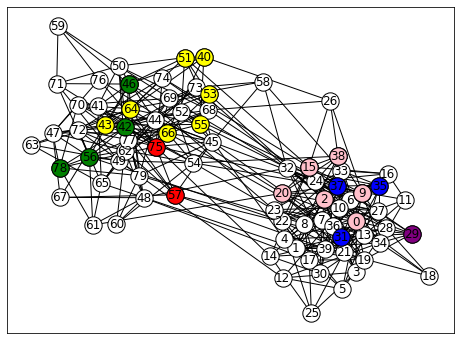

In [13]:
samplingsets = generate_seeds(A,B,N1+N2,0.3) 
plt.figure(figsize=(8,6))
pos = nx.spring_layout(g,seed=0)
nx.draw_networkx(g,pos=pos,node_color='w',edgecolors="k",)
colors = ['yellow','green','blue','red','purple','pink','orange','lightblue']
for i,s in enumerate(samplingsets):
    nx.draw_networkx_nodes(g,pos=pos,nodelist=s, node_color=colors[i],edgecolors="k",lable=False)

## choice of Alpha and Lambda
* The formula for alpha is derived from the optimal conditions，It can help to avoid local cluster X-new values from being less than 0.5.
* The value for lambda can the tuned in self-supervised way, according to X-new values and y_new values, if lambda is too large, the flow will be averagely distributed to each node, if lambda is too small, Most of the flow will be stuck in seeds, only a little bit can flow to the nerigborhood, usually, 2-3 times tuning, a proper lambda can be found and a cluster around the seeds can also be found 

In [14]:
for _ in samplingsets:
    print(_)

[66, 40, 43, 46, 51, 53, 55, 64]
[56, 78, 46, 42]
[9, 35, 38, 31, 37]
[57, 75]
[9, 29, 15, 2]
[0, 2, 38, 9, 20, 15]


iteration: 2999


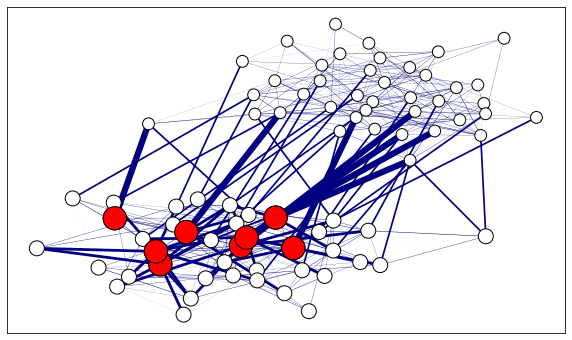

In [16]:
# test the performance of each samplingset, larger one works better
samplingset = samplingsets[0]
ALPHA = len(samplingset)/(N1+N2) 
LAMBDA = 0.05

#### Run the algorithm, update graph every 500 iterations, with node size indicating X_new, 
# edge width indicating y_new
# the red node is the seed
history,y = algorithm(B,g,edge_weights,samplingset,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=True)

In [17]:
# run our algorithm for each batch of seeds, and stack the obtained graph signals into a feature matrix
# feed the feature matrix into Kmeans to get the final cluster identities for each node.
history = []
for samplingset in samplingsets:
    hist,_ = algorithm(B,g,edge_weights,samplingset,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=False)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=2).fit(np.array(history).T) 

true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])
if kmeans.labels_[0] == 0:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

The accuracy is:  1.0


In [82]:
# # BFS method to explore the graph starting from seed nodes

# def bfs(B, node, slack=1):
#     B = B.toarray() 
#     visited = []
#     queue = []
#     diffs = []
#     visited.extend(node)
#     queue.extend(node)
#     while queue:
#         s = queue.pop(0) 

#         for edge in np.where(B[:, s] != 0)[0]:
#             if abs(y)[edge]/edge_weights[edge] > slack * LAMBDA:
# #                 print(edge, np.where(B[edge] != 0))
#                 continue
#             for neighbour in np.where(B[edge] != 0)[0]:
#                 if neighbour == s:
#                     continue
#                 if neighbour not in visited:
#                     visited.append(neighbour)
#                     queue.append(neighbour)
#     return visited
                    
# visited = bfs(B, samplingset,slack=2)
# print("Nodes can be accessed with relaxing saturation condition: \n", sorted(visited))                
# visited_ = bfs(B, samplingset,slack=1)
# print("\n Nodes can be accessed with true saturation condition: \n", sorted(visited_))
# print('\n')
# kmeans = KMeans(n_clusters=2).fit(np.nan_to_num(history[-1]).reshape(-1,1)) 
# print(kmeans.labels_)

# Experiment rings

In [20]:

def algorithm_points(B, edge_weights, samplingset, K=15000, alpha=0.01, lambda_nLasso=None, check_s=False):
    E, N = B.shape
    edge_eights = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5
    
    
    seednodesindicator= np.zeros(N)
    seednodesindicator[samplingset] = 1
    noseednodeindicator = np.ones(N)
    noseednodeindicator[samplingset] = 0
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(edge_eights))
    
    if check_s:
        s = 0.0
        for item in range(len(edge_eights)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += edge_eights[item]
            elif i >= N1 > j:
                s += edge_eights[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * edge_eights), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[samplingset] = (newx[samplingset] + Gamma_vec[samplingset]) / (1 + Gamma_vec[samplingset])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history

In [21]:
def get_cords(circle_r1=2, circle_r2=4, circle_x=0, circle_y=0):
    alpha = 2 * math.pi * random.random()
    r = (circle_r2-circle_r1) * math.sqrt(random.random()) + circle_r1
    x = r * math.cos(alpha) + circle_x
    y = r * math.sin(alpha) + circle_y
    return x, y
def get_A_B_and_edge_weights_points(points,threshold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_
#     print(np.max(A.flatten()))
    row = []
    col = []
    data = []
    edge_weights = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            edge_weights.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    edge_weights = np.array(edge_weights)
    return A, B, edge_weights

def get_points(N1, N2):
    points = []
    for i in range(N1+N2):
        if i < N1:
            x, y = get_cords(2, 4)
        else:
            x, y = get_cords(5, 7)
        points.append((x, y))
    points = np.array(points)
    return points


def run_points(points,samplingset,A, K=1000, alpha=0.01, lambda_nLasso=0.2,n_clusters=2):
  
    start = datetime.datetime.now()
    history = algorithm_points(B, edge_weights, samplingset, K=K, alpha=ALPHA, lambda_nLasso=LAMBDA)
#     print('our method time: ', datetime.datetime.now() - start)

    start = datetime.datetime.now()
    clustering = SpectralClustering(n_clusters=n_clusters,eigen_solver="arpack",affinity="nearest_neighbors",random_state=0).fit(points)
    spectral_labels = clustering.labels_
#     spectral_clustering(A, n_clusters=n_clusters)
#     print ('spectral clustering time: ', datetime.datetime.now() - start)

    
    return history, spectral_labels

In [22]:
N1=3000
N2=3000
points = get_points(N1, N2)
A, B, edge_weights = get_A_B_and_edge_weights_points(points,threshold=0.2)
samplingsets = generate_seeds(A,B,N1+N2,0.1)

initial_seeds [5944 3830  526 5809  662 2551]


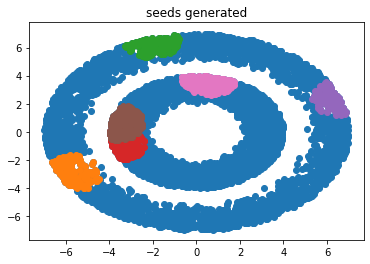

In [23]:
#visulize seeds generated
plt.scatter(points[:, 0], points[:, 1], label='0')
for samplingset in samplingsets:
    plt.scatter(points[samplingset, 0], points[samplingset,1],label='0')
plt.title('seeds generated')
plt.show()
plt.close()

In [24]:
# run our algorithm for each batch of seeds, and stack the obtained graph signals into a feature matrix
# feed the feature matrix into Kmeans to get the final cluster identities for each node.
ALPHA = 50/(N1+N2) 
LAMBDA = 0.05
history = []
for samplingset in samplingsets:
    hist,_ = algorithm(B,g,edge_weights,samplingset,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=False)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=2).fit(np.array(history).T) 

true_labels = np.array([0 for i in range(N1)] + [1 for i in range(N2)])
if kmeans.labels_[0] == 0:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

The accuracy is:  1.0


# Experiment: Moons

In [174]:
N=6000
points = datasets.make_moons(n_samples=N, shuffle=False,noise=0.05)
A,B,edge_weights=get_A_B_and_edge_weights_points(points[0],threshold=0.9)
samplingsets = generate_seeds(A,B,N1+N2,0.1)

initial_seeds [4564 5094   34 1219 1110 1394]


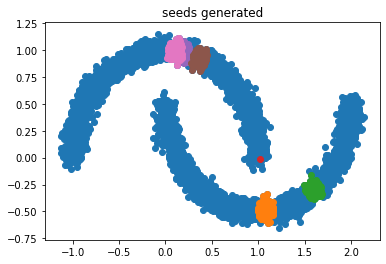

In [175]:
#visulize seeds generated
plt.scatter(points[0][:, 0], points[0][:, 1], label='0')
for samplingset in samplingsets:
    plt.scatter(points[0][samplingset, 0], points[0][samplingset,1],label='0')
plt.title('seeds generated')
plt.show()
plt.close()

In [176]:
# run our algorithm for each batch of seeds, and stack the obtained graph signals into a feature matrix
# feed the feature matrix into Kmeans to get the final cluster identities for each node.
history = []
for samplingset in samplingsets:
    hist,_ = algorithm(B,g,edge_weights,samplingset,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=False)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=2).fit(np.array(history).T) 

true_labels = points[1]
if kmeans.labels_[0] == 0:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

The accuracy is:  1.0


# Experiment: Blobs

In [ ]:
def accuracy(labels, true_labels):
    total_common = 0
    cluster_names = set(true_labels)
    permutations = list(itertools.permutations(cluster_names))
    for permutation in permutations:
        max_common = 0
        for i, cluster_name in enumerate(cluster_names):
            cluster_nodes = np.where(labels == cluster_name)[0]
            cluster_name1 = permutation[i]
            true_nodes = np.where(true_labels == cluster_name1)[0]

            common = len(set(true_nodes) - (set(true_nodes) - set(cluster_nodes)))
            max_common += common

        total_common = max(total_common, max_common)

    return total_common / len(true_labels)


In [ ]:
def plot_full_charts_3clusters(history):
    N = len(history[0])
    x_axis = [i for i in range(len(history))]
    for i in range(N):
        if i < N/3:
            plt.plot(x_axis, history[:, i], label='1', color='red')
        elif N/3<= i < 2*N/3:
            plt.plot(x_axis, history[:, i], label='0', color='green')
        else:
            plt.plot(x_axis, history[:, i], label='0', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('x_hat')
    plt.show()

In [ ]:
N=6000
points = datasets.make_blobs(n_samples=N, cluster_std=1.0,shuffle=False,random_state=170) #make data
A,B,edge_weights=get_A_B_and_edge_weights_points(points[0],threshold=0.2)

samplingsets = generate_seeds(A,B,N1+N2,0.1)

In [ ]:
#visulize seeds generated
plt.scatter(points[0][:, 0], points[0][:, 1], label='0')
for samplingset in samplingsets:
    plt.scatter(points[0][samplingset, 0], points[0][samplingset,1],label='0')
plt.title('seeds generated')
plt.show()
plt.close()

In [443]:
history = []
for samplingset in samplingsets:
    hist,_ = algorithm(B,g,edge_weights,samplingset,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=False)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=3).fit(np.array(history).T) 

In [445]:
true_labels = points[1]
print('Accuracy of our method: ',accuracy(kmeans.labels_,true_labels))
# print('Accuracy of Spectral method: ',accuracy(spectral_labels, true_labels))

Accuracy of our method:  0.9993333333333333


# Experiment: Varied
**Same process as blobs experiment**


In [446]:
N=6000
points = datasets.make_blobs(n_samples=N, cluster_std=[1.0, 2.5, 0.5],shuffle=False,random_state=170)
#
A,B,edge_weights=get_A_B_and_edge_weights_points(points[0],threshold=0.2)

samplingsets = generate_seeds(A,B,N1+N2,0.1)

initial_seeds [4842 2322 3191 4273 5407  530]


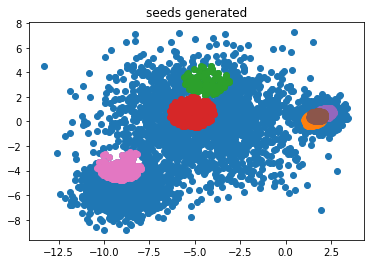

In [447]:
#visulize seeds generated
plt.scatter(points[0][:, 0], points[0][:, 1], label='0')
for samplingset in samplingsets:
    plt.scatter(points[0][samplingset, 0], points[0][samplingset,1],label='0')
plt.title('seeds generated')
plt.show()
plt.close()

In [448]:
history = []
for samplingset in samplingsets:
    hist,_ = algorithm(B,g,edge_weights,samplingset,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=False)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=3).fit(np.array(history).T) 

true_labels = points[1]
print('Accuracy of our method: ',accuracy(kmeans.labels_,true_labels))
# print('Accuracy of Spectral method: ',accuracy(spectral_labels, true_labels))

In [449]:
true_labels = points[1]
print('Accuracy of our method: ',accuracy(kmeans.labels_,true_labels))
# print('Accuracy of Spectral method: ',accuracy(spectral_labels, true_labels))

Accuracy of our method:  0.972


# Experiment: Aniso

**Same process as blobs experiment**

In [453]:
N=6000
points = datasets.make_blobs(n_samples=N, shuffle=False,random_state=8)
points = list(points)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
points[0] = np.dot(points[0], transformation)
A,B,edge_weights=get_A_B_and_edge_weights_points(points[0],threshold=0.2)

samplingsets = generate_seeds(A,B,N1+N2,0.1)

initial_seeds [1334 2672 1812 1583 5032  805]


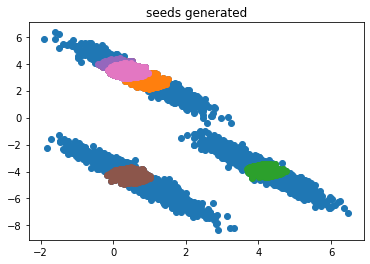

In [454]:
#visulize seeds generated
plt.scatter(points[0][:, 0], points[0][:, 1], label='0')
for samplingset in samplingsets:
    plt.scatter(points[0][samplingset, 0], points[0][samplingset,1],label='0')
plt.title('seeds generated')
plt.show()
plt.close()

In [455]:
history = []
for samplingset in samplingsets:
    hist,_ = algorithm(B,g,edge_weights,samplingset,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=False)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=3).fit(np.array(history).T) 

true_labels = points[1]
print('Accuracy of our method: ',accuracy(kmeans.labels_,true_labels))
# print('Accuracy of Spectral method: ',accuracy(spectral_labels, true_labels))

Accuracy of our method:  1.0


# Experiment: G+L

In [194]:
def make_GU(n1,n2):
    u = np.random.uniform(low=[0,-0.05], high=[8.0,0], size=(n1,2))
    mean=[2,0.2]
    cov=[[0.01,0],[0,0.01]]
    g = np.random.multivariate_normal(mean, cov, n2)
    data = np.concatenate((u,g))
    return data,np.array([0]*n1+[1]*n2)

N1=700
N2=700
points = make_GU(n1=N1,n2=N2)

A,B,edge_weights=get_A_B_and_edge_weights_points(points[0],threshold=0.99)
samplingsets = generate_seeds(A,B,N1+N2,0.1)

#visulize seeds generated
plt.scatter(points[0][:, 0], points[0][:, 1], label='0')
for samplingset in samplingsets:
    plt.scatter(points[0][samplingset, 0], points[0][samplingset,1],label='0')
plt.title('seeds generated')
plt.axis('equal')
plt.show()
plt.close()

# run our algorithm for each batch of seeds, and stack the obtained graph signals into a feature matrix
# # feed the feature matrix into Kmeans to get the final cluster identities for each node.
ALPHA = 5/(N1+N2) 
LAMBDA = 0.01
history = []
for samplingset in samplingsets:
    hist,_ = algorithm(B,g,edge_weights,samplingset,K=1000,alpha=ALPHA,lambda_nLasso=LAMBDA,plot_graph=False)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=2).fit(np.array(history).T) 

true_labels = points[1]
if kmeans.labels_[0] == 0:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

plt.scatter(points[0][np.where(kmeans.labels_ == 1), 0], points[0][np.where(kmeans.labels_ == 1), 1], label='0')
plt.scatter(points[0][np.where(kmeans.labels_ == 0), 0], points[0][np.where(kmeans.labels_ == 0), 1], label='0')
# plt.scatter(points[0][samplingset, 0], points[0][samplingset,1], c='r',label='0')
plt.title('clustering results')
plt.axis('equal')
plt.show()
plt.close()  